 ## Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of dymoval.

First of all let's import some useful packages

In [1]:
from copy import deepcopy
import dymoval as dmv
import numpy as np
import matplotlib.pyplot as plt

Next, assume that we run some experiments and that we logged some measurements that we want to use as dataset. 
Given that at the moment we don't have any real measurement, we can generate random numbers and we assume that these are our logs.

In [2]:
nan_intervals = np.empty(200)
nan_intervals[:] = np.NaN

# INPUT signals
input_signal_names = ["u1", "u2", "u3"]
input_sampling_periods = [0.01, 0.1, 0.1]
input_signal_values = [
    np.hstack(
        (np.random.rand(50), nan_intervals, np.random.rand(400), nan_intervals)
    ),
    np.hstack(
        (
            np.random.rand(20),
            nan_intervals[0:5],
            np.random.rand(30),
            nan_intervals,
        )
    ),
    np.hstack((np.random.rand(80), nan_intervals, np.random.rand(100))),
]

input_signal_units = ["m/s", "%", "°C"]

# OUTPUT signals
output_signal_names = ["y1", "y2", "y3", "y4"]
output_sampling_periods = [0.3, 0.2, 0.1, 0.05]
output_signal_values = [
    np.hstack(
        (np.random.rand(50), nan_intervals, np.random.rand(100), nan_intervals)
    ),
    np.hstack(
        (
            np.random.rand(100),
            nan_intervals[0:50],
            np.random.rand(150),
            nan_intervals,
        )
    ),
    np.hstack(
        (
            np.random.rand(10),
            nan_intervals[0:105],
            np.random.rand(50),
            nan_intervals,
        )
    ),
    np.hstack(
        (
            np.random.rand(20),
            nan_intervals[0:85],
            np.random.rand(60),
            nan_intervals,
        )
    ),
]

output_signal_units = ["m/s", "deg", "°C", "kPa"]

The first thing to do is to map each logged signal into a dymoval *Signal*.

At the end, we should have a list of *dymoval's Signals*.

To create a *dymoval Signal* use the syntax and fill the fields accordingly
to the specified datatypes

*name: dmv.Signal = {
                  "name": str
                  "values": np.ndarray
                  "signal_unit": str
                  "sampling_period": float
                  "time_unit": str
                  }*

In [3]:
in_lst = []
for ii, val in enumerate(input_signal_names):
    temp_in: dmv.Signal = {
        "name": val,
        "values": input_signal_values[ii],
        "signal_unit": input_signal_units[ii],
        "sampling_period": input_sampling_periods[ii],
        "time_unit": "s",
    }

    in_lst.append(deepcopy(temp_in))

out_lst = []
for ii, val in enumerate(output_signal_names):
    # This is the syntax for defining a dymoval signal
    temp_out: dmv.Signal = {
        "name": val,
        "values": output_signal_values[ii],
        "signal_unit": output_signal_units[ii],
        "sampling_period": output_sampling_periods[ii],
    }

    out_lst.append(deepcopy(temp_out))
    
signal_list = [*in_lst, *out_lst]
first_output_idx = len(input_signal_names)

To be sure that we haven't make any mistake - and therefore the signals are good for creating a dymoval *Dataset*, we can validate them through the function *validate_signals()*. If the signals are good, then such a function won't raise any error.

Let's try

In [4]:
dmv.validate_signals(signal_list)

KeyError: "Key ['time_unit'] not found in signal y1."

As we can see, we haven't provided the *time_unit* to some signal. Let's fix it.

In [5]:
out_lst = []
for ii, val in enumerate(output_signal_names):
    # This is the syntax for defining a dymoval signal
    temp_out: dmv.Signal = {
        "name": val,
        "values": output_signal_values[ii],
        "signal_unit": output_signal_units[ii],
        "sampling_period": output_sampling_periods[ii],
        "time_unit": "s",
    }

    out_lst.append(deepcopy(temp_out))
signal_list = [*in_lst, *out_lst]
first_output_idx = len(input_signal_names)

...and now let's validate again

In [6]:
dmv.validate_signals(signal_list)

The function didn't raise any error, meaning that our signals can be used to create a *Dataset* object, but let's first take a look at how our signals look like throuh the function *plot_signals()*.

(<Figure size 640x480 with 9 Axes>, <numpy.flatiter at 0x1d08c793fc0>)

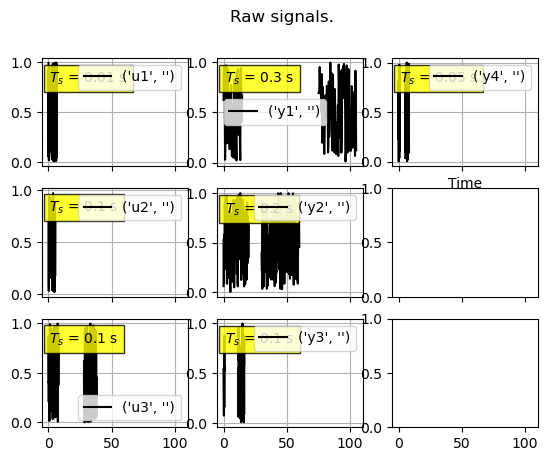

In [7]:
dmv.plot_signals(signal_list)

As we can see, our measurements miss some data and the signals have been also sampled with different sampling periods and have been logged over different time span.

Nevertheless, we can still use them for creating a dymoval *Dataset* but we need to specify which shall be considered input signals and which output signals. 
We further try to re-sample all the signals with a *target_sampling_period* of 0.1 s and consider only the time interval from 0 to 8 seconds. 

In [8]:
ds = dmv.Dataset(
    "my_dataset",
    signal_list,
    input_signal_names,
    output_signal_names,
    target_sampling_period=0.1,
    tin = 0.0,
    tout = 8.0,
)


re-sampled signals = ['u1', 'u2', 'u3', 'y3', 'y4']
excluded signals from dataset =['y1', 'y2']
actual sampling period = 0.1

tin =  0.0 tout = 8.0


As we can see, the signals *y1* and *y2* could not be re-sampled with the target period 0.1 s and therefore they have been excluded from the dataset. 
The list of excluded signals are stored in the attribute *excluded_signals* of the Dataset object. 
To see them you can trivially run the following

In [9]:
ds.excluded_signals

['y1', 'y2']

Let's see how our dataset looks like

(<Figure size 640x480 with 6 Axes>, <numpy.flatiter at 0x1d08c78f5d0>)

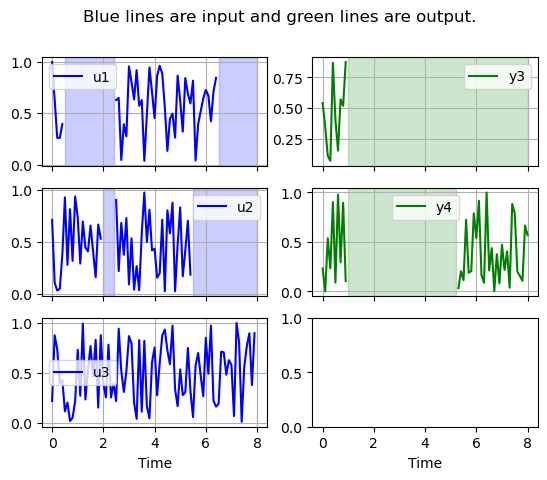

In [10]:
ds.plot()

We can clearly see where we had missing data and we can fill such areas either with a constant value or by interpolation. 
For example, let's fill them by interpolation.

(<Figure size 640x480 with 6 Axes>, <numpy.flatiter at 0x1d08c797490>)

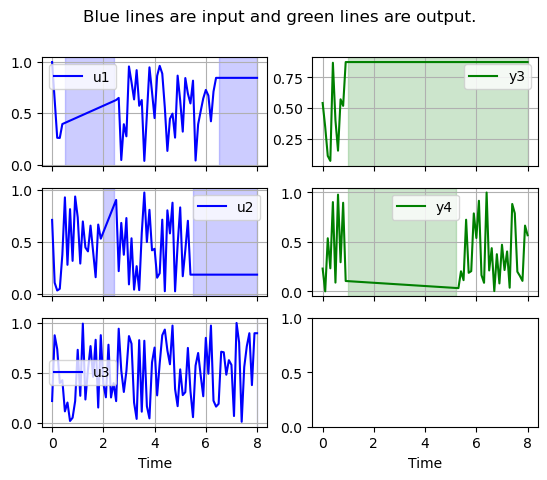

In [11]:
ds_interp = ds.replace_NaNs('interpolate') 
ds_interp.plot()

Note how the Dataset object keeps track of the areas where the missing data have been replaced.

This is very important when we validate our models because we should always validate with respect to real-world data, but sometimes it is not possible to have 100% accurate data. 
Therefore, keeping track of how much the measurements are real or artificial would give us a flavor on the validation results trustworthiness. 

However, we can also take a look the coverage region of such measurements.

(<Figure size 640x480 with 2 Axes>, <numpy.flatiter at 0x1d08c79be80>)

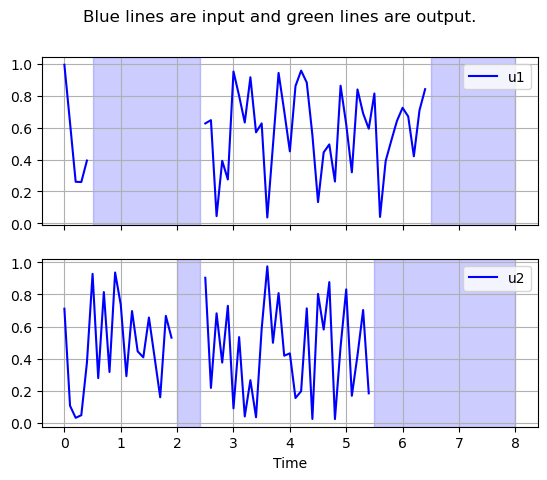

In [12]:
ds.plot(u_labels=["u1","u2"],y=["",""])

(<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <numpy.flatiter at 0x20cf3f17240>)

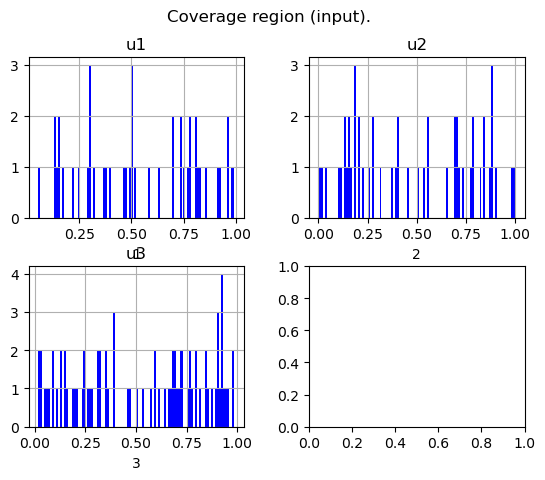

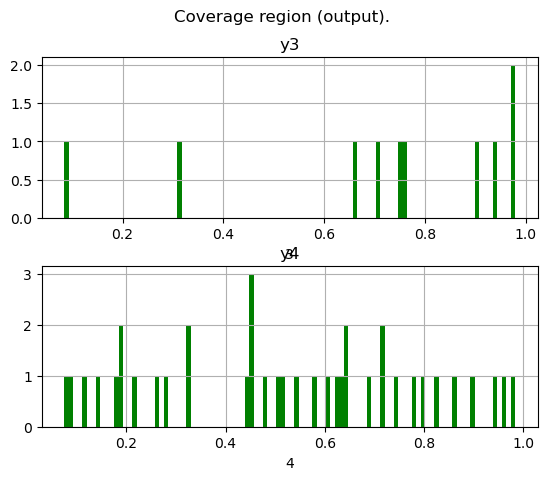

In [24]:
ds.plot_coverage()

...or we can look at their frequency content

(<Figure size 640x480 with 6 Axes>, <numpy.flatiter at 0x20cf3f108a0>)

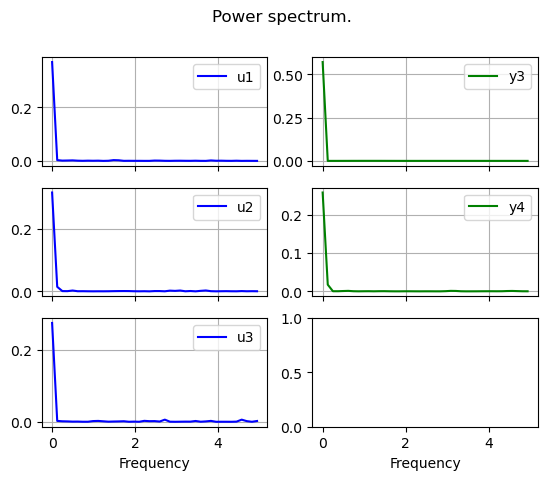

In [26]:
ds_interp.plot_spectrum()

At this point, we can create our *ValidationSession* object using the Dataset *ds_interp* as basis

In [31]:
vs = dmv.ValidationSession("my_validation", ds_interp)

The simulation list now is obviusly empty 

In [29]:
vs.get_simulations_name()

[]

But we can access all the methods and attributes of the stored Dataset directly from the *ValidationSession* object.
For example

In [34]:
vs.Dataset.excluded_signals

['y1', 'y2']

It's now time to run some simulation and check if our models are good or not. 

We don't have any model availale at this point, so we random generate some number and we assume that they are the simulation results of some models

In [35]:
# Model number 1
sim1_name = "Model 1"
sim1_labels = ["my_y1", "my_y2"]
sim1_values = vs.Dataset.dataset["OUTPUT"].values + np.random.rand(
    len(vs.Dataset.dataset["OUTPUT"].values), 2
)

# Model number 2
sim2_name = "Model 2"
sim2_labels = ["your_y1", "your_y2"]

sim2_values = vs.Dataset.dataset["OUTPUT"].values + np.random.rand(
    len(vs.Dataset.dataset["OUTPUT"].values), 2
)


... and then we append the simulation results to our validation session

In [47]:
vs.append_simulation(sim1_name, sim1_labels, sim1_values)
vs.append_simulation(sim2_name, sim2_labels, sim2_values)

ValueError: Simulation name 'Model 2' already exists. 
HINT: check the loaded simulations names with'get_simulations_names()' method.

We can visually compare how the simulation results compare with the Dataset

(<Figure size 640x480 with 4 Axes>, <numpy.flatiter at 0x20cf3f191f0>)

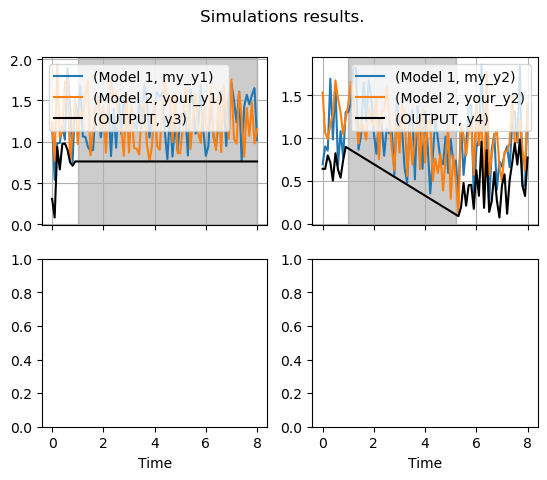

In [39]:
vs.plot_simulations(dataset='only_out')

The validation metrics are automatically computed

In [40]:
vs.validation_results

,Model 1,Model 2
r-square (%),-867.494500,-864.062600
Residuals Auto-corr,0.014775,0.014924
Input-Res. Cross-corr,0.015788,0.014699


Obviously, this was a toy example and the numbers don't say anything really. 

We can also visually inspect the residuals

(<Figure size 640x480 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '$\\hat r_{\\epsilon_0\\epsilon_0}$'}, xlabel='Lags'>,
         <AxesSubplot: title={'center': '$\\hat r_{\\epsilon_0\\epsilon_1}$'}, xlabel='Lags'>],
        [<AxesSubplot: title={'center': '$\\hat r_{\\epsilon_1\\epsilon_0}$'}, xlabel='Lags'>,
         <AxesSubplot: title={'center': '$\\hat r_{\\epsilon_1\\epsilon_1}$'}, xlabel='Lags'>]],
       dtype=object),
 <Figure size 640x480 with 6 Axes>,
 array([[<AxesSubplot: title={'center': '$\\hat r_{u_0\\epsilon_0}$'}, xlabel='Lags'>,
         <AxesSubplot: title={'center': '$\\hat r_{u_0\\epsilon_1}$'}, xlabel='Lags'>],
        [<AxesSubplot: title={'center': '$\\hat r_{u_1\\epsilon_0}$'}, xlabel='Lags'>,
         <AxesSubplot: title={'center': '$\\hat r_{u_1\\epsilon_1}$'}, xlabel='Lags'>],
        [<AxesSubplot: title={'center': '$\\hat r_{u_2\\epsilon_0}$'}, xlabel='Lags'>,
         <AxesSubplot: title={'center': '$\\hat r_{u_2\\epsilon_1}$'}, xlabel='Lags'>]

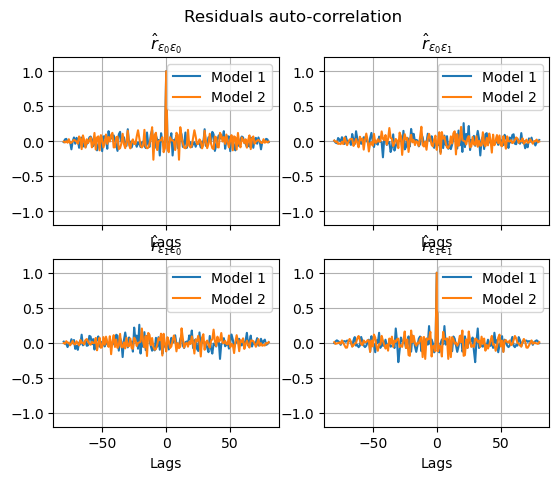

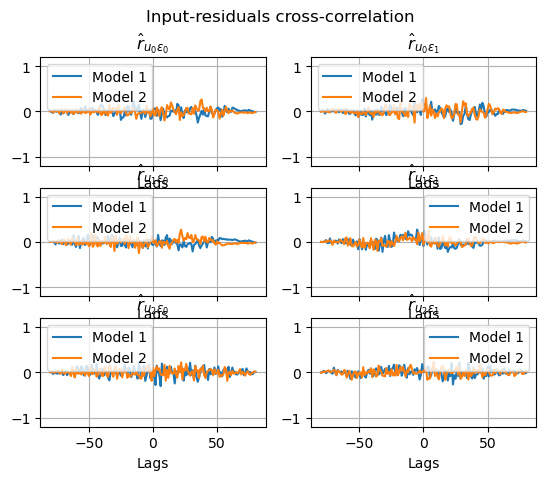

In [41]:
vs.plot_residuals()

And we can perform other operations, like for example removing some simulation results from the list

In [49]:
vs.drop_simulation('Model 1')
vs.get_simulations_name()

['Model 2']

...or to completely clear the simulation list

In [51]:
vs.clear()
vs.get_simulations_name()

[]

Note that it is possible to remove the simulations, but not the *Dataset*

In [52]:
vs.Dataset